# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
# Inspired by https://stackoverflow.com/a/8856387/5353461
import inspect
import re

def describe(arg):
    frame = inspect.currentframe()
    callerframeinfo = inspect.getframeinfo(frame.f_back)
    try:
        context = inspect.getframeinfo(frame.f_back).code_context
        caller_lines = ''.join([line.strip() for line in context])
        m = re.search(r'describe\s*\((.+?)\)$', caller_lines)
        if m:
            caller_lines = m.group(1)
            position = str(callerframeinfo.filename) + "@" + str(callerframeinfo.lineno)

            # Add additional info such as array shape or string length
            additional = ''
            if hasattr(arg, "shape"):
                additional += "[shape={}]".format(arg.shape)
            elif hasattr(arg, "__len__"):  # shape includes length information
                additional += "[len={}]".format(len(arg))

            # Use str() representation if it is printable
            str_arg = str(arg)
            str_arg = str_arg if str_arg.isprintable() else repr(arg)

            print(position, "describe(" + caller_lines + ") = ", end='')
            print(arg.__class__.__name__ + "(" + str_arg + ")", additional)
        else:
            print("Describe: couldn't find caller context")

    finally:
        del frame
        del callerframeinfo

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


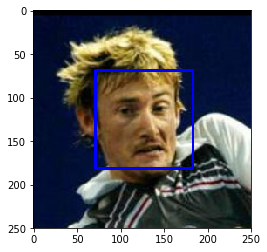

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
image_index = np.random.randint(len(human_files))
img = cv2.imread(human_files[image_index])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

### Allow for caching cell outputs

Some of the below cells take a non-trivial time to run, so I use [`iypcache`](https://github.com/rossant/ipycache) to cache the outputs.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
from tqdm import tqdm_notebook
from collections import OrderedDict

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

dataset = OrderedDict([("Humans", human_files_short), ("Dogs", dog_files_short)])

print('Detecting faces...')

for species, image_files in dataset.items():
    faces = 0
    for image in tqdm_notebook(image_files, desc=species):
        if face_detector(image):
            faces += 1
    percent = faces / len(image_files) * 100
    print("{:>6} with human faces: {:6.2f}%".format(species, percent))


# # # Or a shorter version without pretty progress indicators:

# # is_face = np.vectorize(face_detector)

# # faces_in_humans = is_face(human_files_short).mean() * 100
# # print("Humans with recognised faces: %.2f%%" % faces_in_humans)

# # faces_in_dogs   = is_face(dog_files_short).mean() * 100
# # print("Dogs with recognised faces:   %.2f%%" % faces_in_dogs)

Detecting faces...


HBox(children=(IntProgress(value=0, description='Humans: '), HTML(value='')))


Humans with human faces:  98.00%


HBox(children=(IntProgress(value=0, description='Dogs: '), HTML(value='')))


  Dogs with human faces:  17.00%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)
VGG16.eval()

# check if CUDA is available
use_cuda = torch.cuda.is_available()
    
# Set device for `.to(device)` convenience
device = torch.device('cuda' if use_cuda else 'cpu')

# move model to GPU if CUDA is available
VGG16 = VGG16.to(device)

print(f"Using {device} device for training.")

Using cuda device for training.


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

Image.LOAD_TRUNCATED_IMAGES = True  # Work around some non-perfect images

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path)
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
        
    ])

    transformed = transform(image).to(device).unsqueeze_(0)
    index = VGG16(transformed).detach().argmax(None)
    return index.item()  # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index = VGG16_predict(img_path)
    
    # Indices of the dogs in ImageNet are contiguous
    dog_index_first = 151
    dog_index_last  = 268

    if index in range(dog_index_first, dog_index_last + 1):  # +1 on end range as it is an open interval
        return True
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [9]:
dataset = OrderedDict([("Humans", human_files_short), ("Dogs", dog_files_short)])

print('Detecting dogs...')

for species, image_files in dataset.items():
    dogs = 0
    for image in tqdm_notebook(image_files, desc=species):
        if dog_detector(image):
            dogs += 1
    percent = dogs / len(image_files) * 100
    print("{:>6} detected as dogs: {:6.2f}%".format(species, percent))

Detecting dogs...


HBox(children=(IntProgress(value=0, description='Humans: '), HTML(value='')))


Humans detected as dogs:   0.00%


HBox(children=(IntProgress(value=0, description='Dogs: '), HTML(value='')))


  Dogs detected as dogs: 100.00%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  


|Yellow Labrador|Chocolate Labrador|Black Labrador|
|:---------------:|:------------------:|:--------------:|
|
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">|


We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [10]:
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

common = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                   std=[0.229, 0.224, 0.225]) ])

train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       common])

eval_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      common])
                                      
sets = ['train', 'valid', 'test']

train_dir, valid_dir, test_dir = map(lambda d: '/data/dog_images/' + d, sets)

# TODO: Load the datasets with ImageFolder
image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform= eval_transforms)
image_datasets['test']  = datasets.ImageFolder(test_dir,  transform= eval_transforms)

# Create dataloaders for each of train, valid and test:
loader = {}
for set in sets:
    loader[set] = torch.utils.data.DataLoader(image_datasets[set], batch_size=32, shuffle=True)

n_classes = len(image_datasets['train'].classes)
print(f"There are {n_classes} classes of dogs in the training set.")

There are 133 classes of dogs in the training set.


### Display some sample augmented training set data

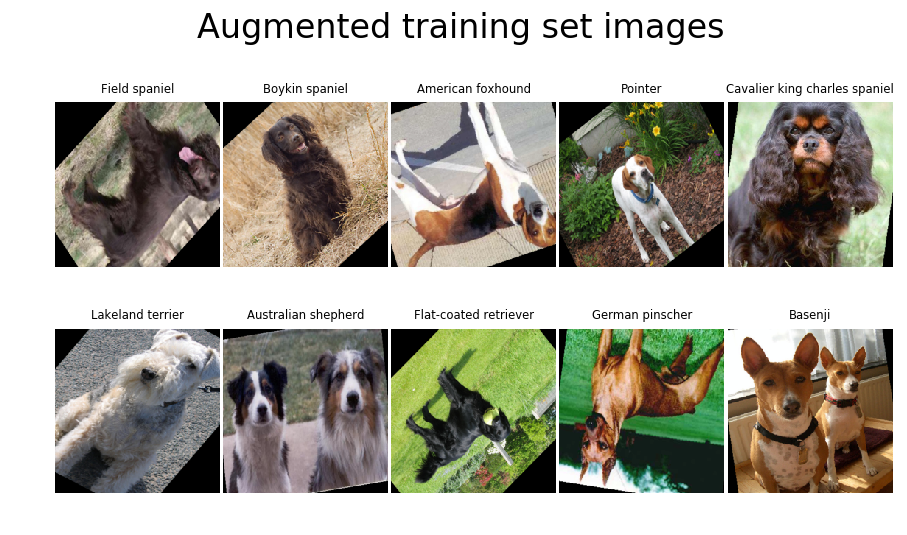

In [11]:
example_rows = 2
example_cols = 5

# # Udacity's version of pytorch is old, this would be better:
# sampler = torch.utils.data.RandomSampler(image_datasets['train'],
#                                          num_samples=example_rows * example_cols)

sampler = torch.utils.data.DataLoader(image_datasets['train'],
                                      batch_size=example_rows * example_cols,
                                      shuffle=True)

# Get a batch of images and labels  
images, indices = next(iter(sampler)) 

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

# Undo transforms.Normalize
def denormalise(image):
    # Udacity version doesn't support Tensor.permute(), so use numpy
    image = image.numpy().transpose(1, 2, 0)  # PIL images have channel last
    mean = [0.485, 0.456, 0.406]
    stdd = [0.229, 0.224, 0.225]
    image = (image * stdd + mean).clip(0, 1)
    return image


# Show a grid of example images

plt.rcParams['figure.dpi'] = 120  # Increase size of pyplot plots

fig, axes = plt.subplots(example_rows, example_cols, figsize=(9, 5)) #  sharex=True, sharey=True)
axes = axes.flatten()
for ax, image, index in zip(axes, images, indices):
    ax.imshow(denormalise(image))
    ax.set_axis_off()
    ax.set_title(class_names[index], fontsize=7)

fig.subplots_adjust(wspace=0.02, hspace=0)
fig.suptitle('Augmented training set images', fontsize=20)
plt.show()

del sampler, images, indices, image, fig, axes  # Free memory

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

* I used an input size of 224 x 224 as this size is the most commonly used for ImageNet, and proven to be effective.
* Resiszing is done by `RandomResizedCrop` for training and by `CenterCrop` for evaluation.
* I decided to augment the dataset by: 
  * Crops from 80% to 100% of the original image
  * Horizontal and vertical flipping
  * Random rotation

Through this augmentation, the network should be robust to images presented at any angle.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        self.valid_loss_min = float('inf')
        
        ## Define layers of a CNN
        channels = (3, 32, 64, 128)  # pairs of in, out channel sizes

        # On a current pytorch version, it would be nicer to use ModuleDict:
        # https://pytorch.org/docs/stable/nn.html#torch.nn.ModuleDict

        self.conv = nn.ModuleList()  # List of convolutional layers
        for i in range(len(channels) - 1):
            self.conv.append(nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=3))
              
        conv_output_params = 6272  # from print x[0].numel() in the forward pass
        
        linears = (conv_output_params, 500, n_classes)  # pairs of in, out channel sizes
        
        self.fc = nn.ModuleList()  # List of fully-connected layers
        for i in range(len(linears) - 1):
            self.fc.append(nn.Linear(in_features=linears[i], out_features=linears[i+1]))
                        
    def forward(self, x):
        ## Define forward behavior
        
        # Apply convolutional layers
        for layer in range(len(self.conv)):
            x = self.conv[layer](x)
            x = F.selu(F.max_pool2d(x, 3))
#             print("Output of conv layer %d: %s" % (layer, str(x.shape)))
        
        # Flatten the the convolutional output
        x = x.view(x.shape[0], -1)
        
#         # Show the number of neurons required in first fully connected layer
#         print("Size of input to fully connected module: %d" % x[0].numel())
        
        # Apply linear layers execept the last
        for layer in range(len(self.fc) - 1):
            x = F.selu(self.fc[layer](x))
        
        # Apply last linear layer
        x = F.log_softmax(self.fc[-1](x), dim=1)
        
        return x

# Test -- Output should be null if foward pass succeeds
Net().to(device)(torch.rand([2, 3, 224, 224]).to(device));  

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  


__Answer:__ 


I started with a maxpool kernel size of 2:

>```
Output of conv layer 0: torch.Size([1, 16, 111, 111])
Output of conv layer 1: torch.Size([1, 32, 54, 54])
Output of conv layer 2: torch.Size([1, 64, 26, 26])
Output of conv layer 3: torch.Size([1, 128, 12, 12])
Size of input to fully connected module: 18432
```

There are too many outputs - I'm aiming for around 8192 inputs to the fully-connected layers (like Resnet-152).

I tried removing the first conv layer with 16 output channels, thinking that removing some parameters would decrease the outputs, but it actually incrased it:

>```
Output of conv layer 0: torch.Size([1, 32, 111, 111])
Output of conv layer 1: torch.Size([1, 64, 54, 54])
Output of conv layer 2: torch.Size([1, 128, 26, 26])
Size of input to fully connected module: 86528
```

I need to reduce the size of the final channels, so I increase the maxpool kernel to 3:

>```
Output of conv layer 0: torch.Size([1, 16, 74, 74])
Output of conv layer 1: torch.Size([1, 32, 24, 24])
Output of conv layer 2: torch.Size([1, 64, 7, 7])
Output of conv layer 3: torch.Size([1, 128, 1, 1])
Size of input to fully connected module: 128
```

This decreased the final layer's channel size too drastically, so I choose to drop a layer:

>```
Output of conv layer 0: torch.Size([2, 32, 74, 74])
Output of conv layer 1: torch.Size([2, 64, 24, 24])
Output of conv layer 2: torch.Size([2, 128, 7, 7])
Size of input to fully connected module: 6272
```

This seemed like a reasonable size of convolutional features output.

I used one hidden layer with dropout in the classifier module to allow for a more complex classifier while reducing the risk of overfitting.

I choose SeLU over ReLU as [this article](https://towardsdatascience.com/gentle-introduction-to-selus-b19943068cd9) asserts that they are superior.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
# Load a previously saved model if it exists
import torch.optim as optim
import os

def load_or_new_model(new_model, pathname=False):
    """Create a new model if no path specified, else load from checkpoint"""

    # Instantiate the model
    model = Net().to(device)
    model.criterion = nn.NLLLoss(size_average=False)
    model.optimizer = optim.Adam(model.parameters())

    if pathname == False or not os.path.exists(pathname):
        return model
    
    # Work around torch 0.4.0 bug: https://github.com/fperazzi/proSR/issues/17
    if use_cuda:
        checkpoint = torch.load(pathname)
    else:
        checkpoint = torch.load(pathname, map_location=lambda storage, loc: storage)

    model.load_state_dict(checkpoint['state_dict'])
    model.optimizer.load_state_dict(checkpoint['optimizer_state'])
    model.valid_loss_min = checkpoint['valid_loss_min']
    print("Loaded saved model from: {}".format(pathname))
    return model

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

### Loss function for validation

In [14]:
def calc_loss(model, set_name, criterion, print_every=False):
    """Calculate the loss of the model upon the dataset specified by set_name"""
    tot_loss = 0
    examples = 0
    correct = 0
    step = 0

    device = 'cuda' if next(model.parameters()).is_cuda else 'cpu'
    
    if print_every:
        print(f"Calculating {set_name} set loss...")

        
    for images, labels in loader[set_name]:
        step += 1

        images, labels = images.to(device), labels.to(device)
        logps = model(images)

        _, top_classes = logps.topk(1)
        loss = criterion(logps, labels)
        tot_loss += loss.item()
        
        equals = labels == top_classes.view(*labels.shape)
        correct += equals.sum().item()
        examples += len(labels)

        loss = tot_loss / examples
        accuracy = correct / examples * 100
                
        if print_every and step % print_every == 0:
            print(f"{set_name.capitalize()} set: "
                  f"Step {step}/{len(loader[set_name])}: cumulative loss = {loss:.5f}, "
                  f"accuracy = {accuracy:.2f}%")

#         if step > 5:
#             break

    if print_every:
        print(f"--- {set_name.capitalize()} set total loss = {loss:.3f}, "
              f"accuracy = {accuracy:.2f}% ---")
    
    return (loss, accuracy)

In [15]:
def checkpoint_save(model, pathname, verbose=False):
    """Save model to file specified by pathname"""

    checkpoint = {'state_dict':      model.state_dict(),
                  'optimizer_state': model.optimizer.state_dict(),                  
                  'valid_loss_min':  model.valid_loss_min,
                 }
    torch.save(checkpoint, pathname)
    if verbose:
        print("Saved model to file: '{}'".format(pathname))

In [16]:
def check_save_validation_loss(model, save_path, set_name, criterion, print_every=False):
    valid_loss, valid_accuracy = calc_loss(model, set_name, criterion, print_every)
    
    # Save model if test loss has decreased
    if valid_loss < model.valid_loss_min:
        print(f"Validation loss reduced from {model.valid_loss_min} to {valid_loss}. (Saving)")
        model.valid_loss_min = valid_loss
        checkpoint_save(model, save_path, verbose=False)
        
    return valid_loss, valid_accuracy

In [17]:
import time  # To time steps / epochs

# Work around error: 
# OSError: image file is truncated (150 bytes not processed)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


train_losses = []
valid_losses = []

# def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
def train(n_epochs, loaders, model, device, save_path):
    """returns trained model"""

    epoch_print_every = 1           # Print summary statistics every <value> batches
    step_print_every = 999          # Print train loss every <value> minibatches
    check_validation_every = False  # Check validation loss every <value> minibatches
    
    model.train()
    for epoch in range(n_epochs):
        step = 0
        epoch_examples = 0
        epoch_correct = 0
        epoch_tot_loss = 0
            
#         print(" --- Starting epoch {}/{} --- ".format(epoch+1, n_epochs))
        epoch_start_time = time.time()

        time_start = time.time()
        for images, labels in loaders['train']:
            step += 1

#             # For debugging:
#             if step > 10:
#                 break
        
            images, labels = images.to(device), labels.to(device)
            model.optimizer.zero_grad()

            logps = model(images)
            _, top_classes = logps.topk(1)
            
            criterion = nn.NLLLoss(size_average=False) 
            loss = model.criterion(logps, labels)

            epoch_tot_loss += loss.item()
            epoch_examples += len(images)

            equals = labels == top_classes.view(*labels.shape)
            epoch_correct += equals.sum().item()
            accuracy = epoch_correct / epoch_examples * 100
            
            loss.backward()
            model.optimizer.step()

            # Possibly print minibatch information
            if step == len(loaders['train']) or step % step_print_every == 0: # and False
                time_elapsed = time.time() - time_start
                print(f"Train epoch {epoch+1}/{n_epochs}, step {step}/{len(loaders['train'])}: "
                      f"loss = {epoch_tot_loss / epoch_examples:.3f}, "
                      f"elapsed = {time_elapsed:.3f}s, accuracy = {accuracy:.2f}%")
                time_start = time.time()

            # Possibly print loss on validation set
            if check_validation_every and step % check_validation_every == 0:
                with torch.no_grad():
                    print("Calculating validation loss...")
                    check_save_validation_loss(model, save_path, 'valid', criterion, print_every=10)

            # End minibatch loop

        # At the end of epoch...
        epoch_elapsed = time.time() - epoch_start_time
#         print(" --- End of training epoch {}/{} --- ".format(epoch+1, n_epochs))

        # Calculate validation set loss, save if it decreased
        with torch.no_grad():
            valid_loss, valid_accuracy = check_save_validation_loss(model, save_path, 'valid', criterion)

        # Update epoch losses
        train_losses.insert(epoch, epoch_tot_loss / len(loaders['train'].dataset))
        valid_losses.insert(epoch, valid_loss)
    
        # Print epoch statistics
        if epoch == n_epochs or epoch % epoch_print_every == 0:
            print(F"Train epoch {epoch+1}/{n_epochs}:",
                f"(train / valid) loss = ({train_losses[epoch]:.5f} / {valid_losses[epoch]:.5f}),",
                # f"elapsed time = {epoch_elapsed:.3f}s,
                f"(train / valid) accuracy = ({accuracy:.2f}% / {valid_accuracy:.2f}%)")

        # End epoch loop
        
    return model

In [ ]:
train_model = True           # Allow skipping training to continue to transfer learning exercise
train_from_beginning = True  # Allow retraining; forgetting all learning

epochs = 7
save_path = 'model_scratch.pt'

if train_model:
    if train_from_beginning:
        model_scratch = load_or_new_model(Net(), pathname=False)
    else:
        model_scratch = load_or_new_model(Net(), pathname=save_path)
    model_scratch = train(epochs, loader, model_scratch, device, save_path)
    
# Load the best performing model
model_scratch = load_or_new_model(Net(), pathname=save_path)

In [ ]:
# Show the losses decreasing during training
fig = plt.figure()
plt.plot(train_losses, label='Training')
plt.plot(valid_losses, label='Validation')
fig.suptitle('Losses during training', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = model.criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loader, model_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict


# Return a Module based on `base_model` class for transfer learning.
# `classifier` is a Module instance taking a flattened input with size of final convolutional feature detector

def transfer_learner(base_model, classifier):
    model = base_model(pretrained=True)

    # Remove last module from model
    classifier_name, old_classifier = model._modules.popitem()

    # Get the first layer which not wrapped in a Sequential module
    while isinstance(old_classifier, nn.Sequential):
        old_classifier = next(old_classifier.children())
        
    classifier_input_size = old_classifier.in_features

    # Don't train the feature detector
    for param in model.parameters():
        param.requires_grad = False

    # Add an Identity module in place of the last module
    model.add_module(classifier_name, classifier)

    return model.to(device)

class DogClassifier(nn.Module):
    def __init__(self, input_features, hidden_layer_size):
        super().__init__()
        self.fc = nn.Sequential(OrderedDict([
                                   ('fc1', nn.Linear(input_features, hidden_layer_size)),
                                   ('activation', nn.SELU()),
                                   ('dropout', nn.Dropout(p=0.5)),
                                   ('fc2', nn.Linear(hidden_layer_size, n_classes)),
                                   ('output', nn.LogSoftmax(dim=1))
                                   ]))
    def forward(self, x):
        return self.fc(x)

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

While Resnet152 has the best accuracy of the [pytorch models](https://pytorch.org/docs/stable/torchvision/models.html), it takes a long time to train given the number of layers.  I chose to use VGG16 with batch normalisation which is in a sweet spot for both accuracy and speed.

I use the convolutional layers as feature detectors, and replace the fully connected layers with my own classifier.

The output of 133 is determined by the number of classes, and I select a value of 768 hidden neurons which seems like a intermediate value.

I choose SeLU over ReLU as [this article](https://towardsdatascience.com/gentle-introduction-to-selus-b19943068cd9) asserts that they are superior.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
# See the code for load_or_new_model() above.

# criterion_transfer = nn.NLLLoss(size_average=False)
# optimizer_transfer = optim.Adam(model.parameters())

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model

# VGG16 outputs 25088 features from it's final convolutional module
model_transfer = transfer_learner(models.vgg16_bn, DogClassifier(25088, 768)).to(device)
model_transfer = load_or_new_model(model_transfer, pathname=False)  # Set criterion, optimizer

epochs = 40
save_path = 'model_transfer.pt'


train_model = True           # Allow skipping training to quickly continue to next exercise
train_from_beginning = True  # Allow retraining; forgetting all learning

if train_model:
    if train_from_beginning:
        model_scratch = load_or_new_model(Net(), pathname=False)
    else:
        model_scratch = load_or_new_model(Net(), pathname=save_path)
    model_transfer = train(epochs, loader, model_transfer, device, save_path)
    
# Load the model that got the best validation accuracy
model_transfer = load_or_new_model(model_transfer, pathname='model_transfer.pt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loader, model_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path)
    transformed = eval_transforms(image).to(device).unsqueeze_(0)
    index = model_transfer(transformed).argmax()
    return class_names[index]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
def imshow(img_path):
    """Display an image witout axis markings"""
#     display(Image.open(img_path))  # Works, but displays images too large
    image = Image.open(img_path)
    fig = plt.imshow(image)
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
## Handle cases for a human face, dog, and neither

def run_app(img_path): 

    imshow(img_path)
    if dog_detector(img_path):
        print("Detected a dog of breed: %s\n\n" % predict_breed_transfer(img_path))
    elif face_detector(img_path):
        print("Detected a human which looks like a dog of breed: %s\n\n" % predict_breed_transfer(img_path))
    else:
        print("Hmmm, this doesn't look like either a human or a dog.\n\n")    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Suggestions for improvement

1. Crop images tightly around faces. Some dataset images I saw contained other partial faces, or hands. The dog type prediction would be better if it were only based on the face and not other background items.

1. If there is an unknown image, and there is a high confidence ImageNet prediction, then predict that object.

1. I was surprised to see the third picture (a fox) detected as a human, even though the check for "is a dog?" is done before "is a human?". This picture managed to trick both detectors. I would like to investigate the performance statistics of various face and dog detectors to see if there is something more performant. 

1. Getting a probability of dog-ness or human-ness would help give extra information about the confidence of the predictions.

In [ ]:
# Show some example predictions

plt.rcParams['figure.dpi'] = 70  # Don't make images too big

image_files = ['airplane.jpg', 'australian_kelpie.jpg', 'fox.jpg', 'jenny.jpg',
               'australian_cattle_dog.jpg', 'cat.jpg', 'me.jpg', 'monkey.jpg']

for img_path in image_files:
    run_app(img_path)